In [57]:
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
df = pd.read_csv("BREAKOUT1.csv")

In [26]:
df = df[(df["90s"] >= 5.0) & (df["Age"] < 24)].copy()

In [27]:
df["breakout_index"] = (
    0.35 * df["npxG"] +
    0.25 * df["xA"] +
    0.15 * df["PrgC"] +
    0.15 * df["CPA"] +
    0.10 * df["SuccTkon"]
)

In [28]:
df["breakout_index"] = (df["breakout_index"] - df["breakout_index"].min()) / (
    df["breakout_index"].max() - df["breakout_index"].min()
)

In [29]:
model = bmb.Model(
    "breakout_index ~ Age + ELO + PrgC + CPA + SuccTkon + (1|Squad)",
    data=df,
    family="gaussian"
)
fitted = model.fit(draws=1000, chains=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, Age, ELO, PrgC, CPA, SuccTkon, 1|Squad_sigma, 1|Squad_offset]


/Users/walidahmed/.local/share/virtualenvs/DataScience-Kz5g2voH/lib/python3.11/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [54]:
# 1) Summarize the posterior to get mean estimates of each coefficient
posterior_summary = az.summary(
    fitted,
    var_names=["Intercept", "Age", "ELO", "PrgC", "CPA", "SuccTkon"]
)
coef_means = posterior_summary["mean"]  
# 2) Compute the Bayesian point-estimate breakout score for each player
df["posterior_mean"] = (
    coef_means["Intercept"] 
    + coef_means["Age"]    * df["Age"]
    + coef_means["ELO"]    * df["ELO"]
    + coef_means["PrgC"]   * df["PrgC"]
    + coef_means["CPA"]    * df["CPA"]
    + coef_means["SuccTkon"] * df["SuccTkon"]
)

# 3) Show top breakout candidates
top_breakouts = df.sort_values("posterior_mean", ascending=False)
print(top_breakouts[["Player", "Squad", "Age", "90s", "posterior_mean"]].head(50))

                    Player            Squad   Age   90s  posterior_mean
301            Jeremy Doku  Manchester City  22.0  16.8         0.97487
309     Callum Hudson-Odoi  Nott'ham Forest  23.0  24.4         0.81907
321          Ethan Nwaneri          Arsenal  17.0   9.9         0.80936
163           Ryan Longman        Hull City  23.0   5.3         0.77798
47             Rayan Kolli              QPR  19.0   9.1         0.76378
128         Amario Duberry        Blackburn  19.0   8.0         0.74893
328                  Sávio  Manchester City  20.0  19.6         0.73393
130          Aidomo Emakhu         Millwall  20.0   7.7         0.72175
98            Cian Ashford     Cardiff City  19.0  16.9         0.71973
324           Jacob Ramsey      Aston Villa  23.0  18.0         0.71775
251           Noni Madueke          Chelsea  22.0  22.6         0.71692
197            Sam Silvera       Portsmouth  23.0   5.0         0.71120
73           Yousef Salech     Cardiff City  22.0  14.2         

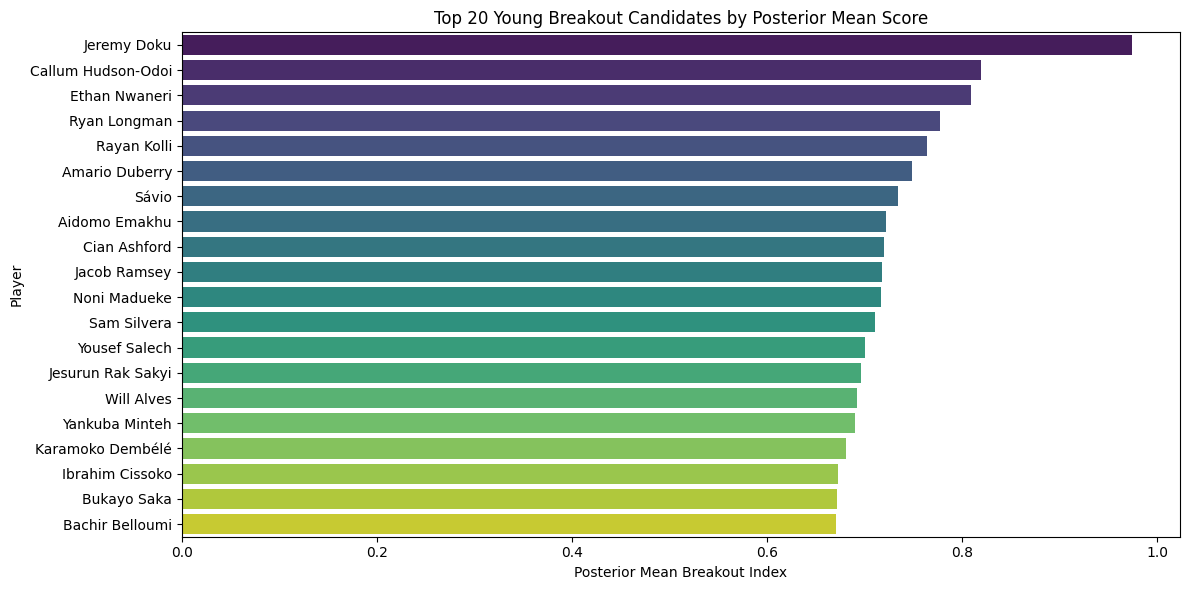

In [61]:
df_sorted = df.sort_values("posterior_mean", ascending=False).reset_index(drop=True)
top20 = df_sorted.head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top20, y="Player", x="posterior_mean", palette="viridis")
plt.title("Top 20 Young Breakout Candidates by Posterior Mean Score")
plt.xlabel("Posterior Mean Breakout Index")
plt.ylabel("Player")
plt.tight_layout()
plt.show()

/Users/walidahmed/.local/share/virtualenvs/DataScience-Kz5g2voH/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


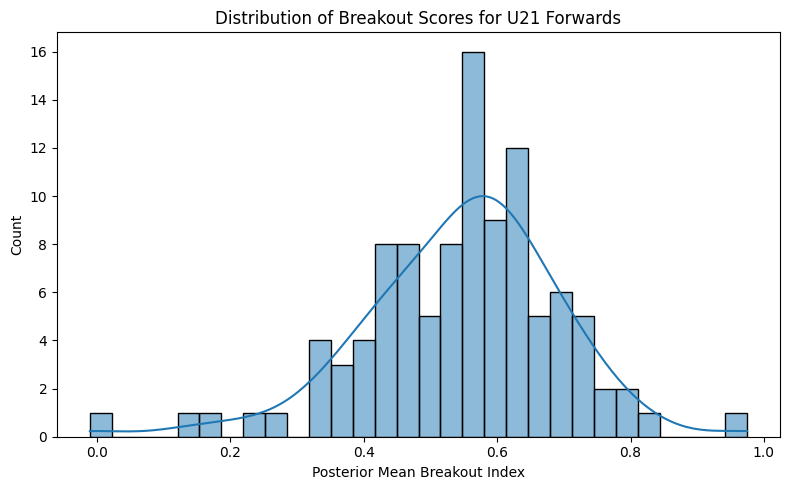

In [62]:
plt.figure(figsize=(8, 5))
sns.histplot(df_sorted["posterior_mean"], bins=30, kde=True)
plt.title("Distribution of Breakout Scores for U21 Forwards")
plt.xlabel("Posterior Mean Breakout Index")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

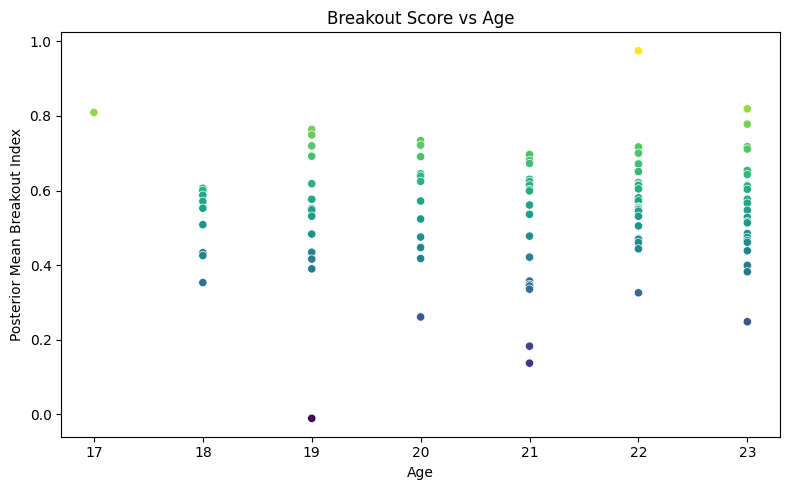

In [63]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_sorted, x="Age", y="posterior_mean", hue="posterior_mean", palette="viridis", legend=False)
plt.title("Breakout Score vs Age")
plt.xlabel("Age")
plt.ylabel("Posterior Mean Breakout Index")
plt.tight_layout()
plt.show()